This notebook illustrates how the SPIRE Prior model works.

## Setup
import relevant modules

In [1]:
from astropy.io import ascii
import pylab as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d

import pystan
import numpy as np

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Filters
Define filter functions

In [2]:
class FilterDefinition:
    def __init__(self):
        """
        Placeholder for the filter definition information.
        """
        self.name = None
        self.wavelength = None
        self.transmision = None

class FilterFile:
    def __init__(self, file='FILTER.RES.v8.R300'):
        """
        Read a EAZY (HYPERZ) filter file.
        """
        fp = open(file)
        lines = fp.readlines()
        fp.close()
        
        filters = []
        wave = []
        for line in lines:
            try:
                lspl = np.cast[float](line.split())
                wave.append(lspl[1])
                trans.append(lspl[2])
            except (ValueError,IndexError):
                if len(wave) > 0:
                    new_filter = FilterDefinition()
                    new_filter.name = header
                    new_filter.wavelength = np.cast[float](wave)
                    new_filter.transmission = np.cast[float](trans)
                    filters.append(new_filter)
                    
                header = ' '.join(line.split()[1:])
                wave = []
                trans = []
        # last one
        new_filter = FilterDefinition()
        new_filter.name = header
        new_filter.wavelength = np.cast[float](wave)
        new_filter.transmission = np.cast[float](trans)
        filters.append(new_filter)
           
        self.filters = filters
        self.NFILT = len(filters)
    
    def names(self):
        """
        Print the filter names.
        """
        for i in range(len(self.filters)):
            print '%5d %s' %(i+1, self.filters[i].name)
    
    def write(self, file='xxx.res', verbose=True):
        """
        Dump the filter information to a filter file.
        """
        fp = open(file,'w')
        for filter in self.filters:
            fp.write('%6d %s\n' %(len(filter.wavelength), filter.name))
            for i in range(len(filter.wavelength)):
                fp.write('%-6d %.5e %.5e\n' %(i+1, filter.wavelength[i], filter.transmission[i]))
        
        fp.close()
        if verbose:
            print 'Wrote <%s>.' %(file)
            
    def search(self, search_string, case=True, verbose=True):
        """ 
        Search filter names for `search_string`.  If `case` is True, then
        match case.
        """
        import re
        
        if not case:
            search_string = search_string.upper()
        
        matched = []
        
        for i in range(len(self.filters)):
            filt_name = self.filters[i].name
            if not case:
                filt_name = filt_name.upper()
                
            if re.search(search_string, filt_name) is not None:
                if verbose:
                    print '%5d %s' %(i+1, self.filters[i].name)
                matched.append(i)
        
        return np.array(matched)

In [3]:
def fnu_filt(sed_fnu,filt_nu,filt_trans,nu_0,sed_f0):
    #f_nu=Int(d_nu f_nu R_nu)/Int(d_nu (nu/nu_0)^-1 R_nu)
    numerator=np.trapz(sed_fnu*filt_trans,x=filt_nu)
    denominator=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    
    #colour correction
    #C=Int(d_nu (nu/nu_0)^-1 R_nu)/Int(d_nu (f(nu)/f(nu_0)) R_nu)
    C_num=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    C_denom=np.trapz(filt_trans*(sed_fnu/sed_f0),x=filt_nu)

    
    return (numerator/denominator)*(C_num/C_denom)


In [4]:
filter=FilterFile(file="/Users/pdh21/astrodata/COSMOS/WP5_COSMOS_XIDplus_P2/filters.res")
SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]

## SEDs
Import Berta et al. 2013 templates

In [5]:
import os
temps=os.listdir('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/')

## Redshift Grid
I need to create a redshift pdf, ideally with reasonable spacings in wavelength space. Since the greatest change in wavelength comes at lower redshift, it seems appropriate to have increase intervals in redshift pdf as a function of redshift. Below shows derivation of how to get equal spacing in wavelength as a function of redshift for the three SPIRE bands: 
- $\lambda_{emitt}=\frac{\lambda_{obs.}}{1+z}$
- $\mathrm{d}\lambda_{emitt} = -\frac{\lambda_{obs.}}{(1+z)^2}\mathrm{d}z$
- $\mathrm{d}z=\frac{\mathrm{d}\lambda_{emitt}}{\lambda_{obs.}}(1+z)^2$
- where $\mathrm{d}\lambda_{emitt}=(\frac{\lambda_{obs.}}{1+z_{low}} - \frac{\lambda_{obs.}}{1+z_{up}})/\mathrm{no.points}$
- $\mathrm{d}\lambda_{emitt}=\lambda_{obs.}(1-\frac{1}{z_{up}+1})/\mathrm{no.points}$
- $\mathrm{d}z=(1+z)^2(1-\frac{1}{z_{up}+1})/\mathrm{no.points}$

In [6]:
n_p=20#number of redshift points
z_l=7#redshift upper limit

red=np.zeros(n_p)
lambda_emit=np.empty(n_p*3.0)
lambda_emit[[0,n_p,n_p*2]]=[250.0,350.0,500.0]
for i in range(0,n_p-1):
    red[i+1]=red[i]+((1-1.0/(z_l+1))/n_p)*(1+red[i])**2
    lambda_emit[i+1]=250.0/(1+red[i+1])
    lambda_emit[i+1+n_p]=350.0/(1+red[i+1])
    lambda_emit[i+1+2*n_p]=500.0/(1+red[i+1])


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Redshift the SEDS
Redshift each SED and convolve with SPIRE filters

In [7]:
col_berta=np.empty((3,red.size,len(temps)))
for i in range(0,len(temps)):
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[i])
    flux=template['col2']*(template['col1']**2)/3E8
    wave=template['col1']/1E4

    for z in range(0,red.size):
        sed=interp1d((red[z]+1.0)*wave, flux)
        col_berta[0,z,i]=fnu_filt(sed(SPIRE_250.wavelength/1E4),3E8/(SPIRE_250.wavelength/1E10),SPIRE_250.transmission,3E8/250E-6,sed(250.0))
        col_berta[1,z,i]=fnu_filt(sed(SPIRE_350.wavelength/1E4),3E8/(SPIRE_350.wavelength/1E10),SPIRE_350.transmission,3E8/350E-6,sed(350.0))
        col_berta[2,z,i]=fnu_filt(sed(SPIRE_500.wavelength/1E4),3E8/(SPIRE_500.wavelength/1E10),SPIRE_500.transmission,3E8/500E-6,sed(500.0))

## XID+ tile
Using the master prior, cut down to specific tile and run relevant routines to prepare for fit: i.e. get pointing matrix, and set flux priors

In [16]:
import xidplus
from xidplus import moc_routines
import pickle
output_folder='/Users/pdh21/astrodata/Lockman-SWIRE/output/'

with open(output_folder+'Master_prior.pkl', "rb") as f:
        Master = pickle.load(f)

      
Tile=1554228
order=10
tiles=Master['tiles']
order=Master['order']
prior250=Master['psw']
prior350=Master['pmw']
prior500=Master['plw']


moc=moc_routines.get_fitting_region(order,Tile)
prior250.set_tile(moc)
prior350.set_tile(moc)
prior500.set_tile(moc)

print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'there are '+ str(prior250.snpix)+' pixels'

prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

print 'set prior upper limit'
prior250.flux_scale(log=False)
prior250.upper_lim_map()
prior250.lower_lim_flux(0.01)
prior350.flux_scale(log=False)
prior350.upper_lim_map()
prior350.lower_lim_flux(0.01)
prior500.flux_scale(log=False)
prior500.upper_lim_map()
prior500.lower_lim_flux(0.01)


from xidplus.stan_fit import SPIRE

fitting 23 sources 

there are 2508 pixels
set prior upper limit


In [9]:
#Folder containing prior input catalogue
folder='../../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'
from astropy.io import fits
hdulist = fits.open(folder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
f_src=fcat['S100']
sgood=f_src >0.050
fcat=fcat[sgood]
print fcat[prior250.ID].Z_OBS

[ 1.32501483  2.10361338  0.34718263  1.63447714  1.58464575  1.67547154
  1.74785495  1.53241515  1.31157732  3.08098221  0.93332648  0.91243708
  0.24596667  0.39743865  1.09477043  2.38517237  0.25812232  2.11748552
  1.72655034  0.73382866  1.92461252  1.1004324   0.18689907  1.39497828
  1.39638233  1.46489739  3.7827878   0.1859287   0.18226182  0.18235135
  0.18321002  0.55589271  0.36140132  2.06023979  1.67735744  1.52719164
  1.69305444  1.50082922  0.26510096  1.49064994  1.40363336  2.85857248
  0.35811758  0.04376566  0.86494029  0.29150856  0.21377146  0.26544487
  1.11467338  1.62115741  2.61927414  2.42718816  1.8598485   1.00178337
  0.99742711  0.99826157  1.00615716  1.0015223   0.9996711   1.00226831
  1.02103186  3.32226801  1.48921776  1.4883759   1.42442703  0.17120254
  0.79916453  0.6404016   1.30601501  1.6509304   0.97254479  1.25652909
  1.49851012  1.52178574  2.37056541  0.82464004  2.73738241  0.53606617
  0.66076756  1.2459178   0.98117185  1.23398113  0

## Get Redshift PDFs
First load redshifts from original catalogue, and then create discrete pdf based on redshift grid

In [10]:
#Folder containing prior input catalogue
folder='../../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'
from astropy.io import fits
hdulist = fits.open(folder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
f_src=fcat['S100']
sgood=f_src >0.050
fcat=fcat[sgood]


In [11]:
from scipy.stats import truncnorm
sig=0.2
redpdf=np.zeros((prior250.nsrc,red.size))
for i in range(0,prior250.nsrc):
    rv = truncnorm(0.0,3.0,fcat[prior250.ID-1].Z_OBS[i],sig)
    redpdf[i,:-1]=rv.cdf(red[1:])-rv.cdf(red[:-1])
redpdf[redpdf<1E-5]=1E-6
redpdf=np.log(redpdf)

## Choose SEDS
Select which SEDS to use, and resize

In [12]:
SEDs=col_berta[:,:,[0,1]].reshape(3*red.size,2)
print SEDs.shape

(60, 2)


## Run XID+
Run XID+ using original XID+ and XID+SED_SPM, then generate posterior class from run

In [17]:
fit_orig=SPIRE.all_bands(prior250,prior350,prior500,chains=4,iter=1000)
#fit=SPIRE.all_bands_SPM(prior250,prior350,prior500,redpdf,SEDs,chains=4,iter=1000)
#posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])
posterior_orig=xidplus.posterior_stan(fit_orig,[prior250,prior350,prior500])


/Users/pdh21/HELP/XID_plus/scripts/test_run/XID+SPIRE.pkl found. Reusing


/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr

In [18]:
outfile=output_folder+'Tile_'+str(Tile)+'_'+str(order)+'.pkl'
with open(outfile, 'wb') as f:
   pickle.dump({'psw':prior250,'pmw':prior350,'plw':prior500,'posterior':posterior_orig},f)
#outfile=output_folder+'Lacy_test_file_SPM_'+str(Tile)+'_'+str(order)+'.pkl'
#with open(outfile, 'wb') as f:
#   pickle.dump({'psw':prior250,'pmw':prior350,'plw':prior500,'posterior':posterior},f)

In [19]:
prior250.moc.write(output_folder+'Moc_'+str(Tile)+'_'+str(order))

## Load XID+ runs
Alternatively load up runs

In [16]:
#infile='Lacy_test_file_'+str(tiles[taskid-1])+'_'+str(order)+'_SPM.pkl'

#with open(infile, "rb") as f:
 #   obj = pickle.load(f)
#prior250=obj['psw']
#prior350=obj['pmw']
#prior500=obj['plw']
#posterior=obj['posterior']

infile='Lacy_test_file_'+str(tiles[taskid-1])+'_'+str(order)+'.pkl'

with open(infile, "rb") as f:
    obj = pickle.load(f)
posterior_orig=obj['posterior']


## SED_SPM Prior
Generate random draws based on the SED_SPM Prior

In [18]:
fit_prior=SPIRE.all_bands_SPM_prior(prior250,prior350,prior500,redpdf,SEDs,chains=4,iter=1000)

(60, 2)
/Users/pdh21/HELP/XID_plus/scripts/test_run/SED_SPM.stan.pkl not found. Compiling


/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr

In [19]:
posterior_prior=xidplus.posterior_stan(fit_prior,[prior250,prior350,prior500])


In [20]:
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd


/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


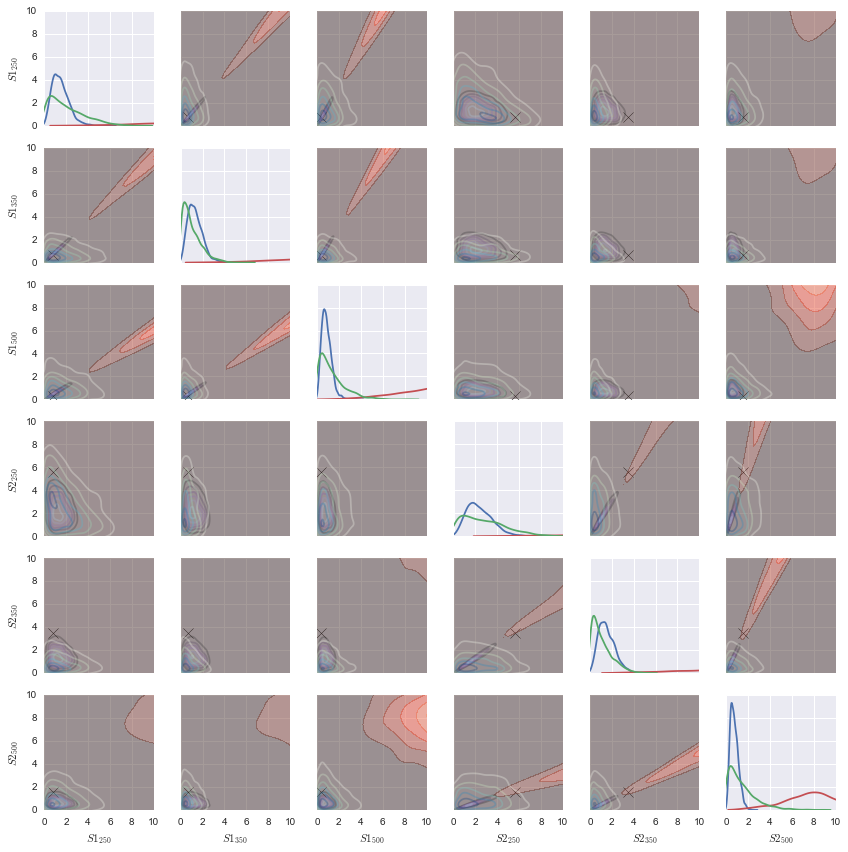

In [25]:
s1=103
s2=80
df = pd.DataFrame(posterior.stan_fit[:,:,[s1,s1+prior250.nsrc+1,s1+((prior250.nsrc+1)*2),s2,s2+prior250.nsrc+1,s2+((prior250.nsrc+1)*2)]].reshape(2000,6),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g = sns.PairGrid(df,size=2)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="BuPu_d",n_levels=6,alpha=0.3)
df2 = pd.DataFrame(np.tile([fcat[prior250.ID-1].S250[s1],fcat[prior250.ID-1].S350[s1],fcat[prior250.ID-1].S500[s1],fcat[prior250.ID-1].S250[s2],fcat[prior250.ID-1].S350[s2],fcat[prior250.ID-1].S500[s2]],(2,1)),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g.data=df2
g.map_offdiag(plt.scatter,marker='x', c='k', s=100,alpha=1)
g.data=pd.DataFrame(posterior_prior.stan_fit[:,:,[s1,s1+prior250.nsrc+1,s1+((prior250.nsrc+1)*2),s2,s2+prior250.nsrc+1,s2+((prior250.nsrc+1)*2)]].reshape(2000,6),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g.map_diag(sns.kdeplot,c='r')
g.map_offdiag(sns.kdeplot, cmap="OrRd_d", n_levels=6,alpha=0.5)
g.data=pd.DataFrame(posterior_orig.stan_fit[:,:,[s1,s1+prior250.nsrc+1,s1+((prior250.nsrc+1)*2),s2,s2+prior250.nsrc+1,s2+((prior250.nsrc+1)*2)]].reshape(2000,6),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g.map_diag(sns.kdeplot,c='g')
g.map_offdiag(sns.kdeplot, cmap="GnBu", n_levels=6,alpha=0.3)


g.set(ylim=(0,10))
g.set(xlim=(0,10))
g.savefig('tri_'+str(s1)+'_'+str(s2)+'.png')

In [27]:
outfile=output_folder+'Lacy_test_file_'+str(tiles[taskid-1])+'_'+str(order)+'_SPM.pkl'
with open(outfile, 'wb') as f:
   pickle.dump({'psw':prior250,'pmw':prior350,'plw':prior500,'posterior':posterior},f)

## Colour and Redshift

In [60]:
tiles=moc_routines.get_HEALPix_pixels(14,prior250.sra[131],prior250.sdec[131],unique=True)


In [61]:
moc=moc_routines.get_fitting_region(14,tiles[0])


In [62]:
import copy
prior250_red=copy.copy(prior250)
prior350_red=copy.copy(prior350)
prior500_red=copy.copy(prior500)



In [63]:
inra=np.repeat(prior250.sra[131],21)
indec=np.repeat(prior250.sdec[131],21)

In [114]:
print red.size
prior250_red.sra[0:21]=inra
prior350_red.sra[0:21]=inra
prior500_red.sra[0:21]=inra
prior250_red.sdec[0:21]=indec
prior350_red.sdec[0:21]=indec
prior500_red.sdec[0:21]=indec

prior250_red.set_tile(moc)
prior350_red.set_tile(moc)
prior500_red.set_tile(moc)

print 'fitting '+ str(prior250_red.nsrc)+' sources \n'
print 'there are '+ str(prior250_red.snpix)+' pixels'



print 'set prior upper limit'
prior250_red.flux_scale(log=False)
prior250_red.upper_lim_flux(100.0)
prior250_red.lower_lim_flux(0.01)
prior250_red.flux_scale(log=False)
prior350_red.upper_lim_flux(100)
prior350_red.lower_lim_flux(0.01)
prior350_red.flux_scale(log=False)
prior500_red.upper_lim_flux(100)
prior500_red.lower_lim_flux(0.01)
prior500_red.flux_scale(log=False)


20
fitting 22 sources 

there are 11 pixels
set prior upper limit


In [115]:
from scipy.stats import truncnorm
sig=0.01
redpdf=np.zeros((prior250_red.nsrc,red.size))
for i in range(0,red.size):
    rv = truncnorm(0.0,3.0,red[i],sig)
    redpdf[i,:-1]=rv.cdf(red[1:])-rv.cdf(red[:-1])
redpdf[[20,21],:]=1.0/20.0
redpdf[redpdf<1E-5]=1E-6
redpdf=np.log(redpdf)

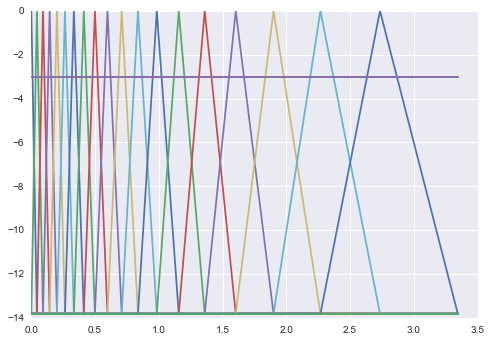

In [116]:
for i in range(0,22):
    plt.plot(red,redpdf[i,:])

In [117]:
fit_red=SPIRE.all_bands_SPM_prior(prior250_red,prior350_red,prior500_red,redpdf,SEDs,chains=4,iter=1000)
posterior_red=xidplus.posterior_stan(fit_red,[prior250_red,prior350_red,prior500_red])


(60, 2)
/Users/pdh21/HELP/XID_plus/scripts/test_run/SED_SPM.stan.pkl found. Reusing


/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr

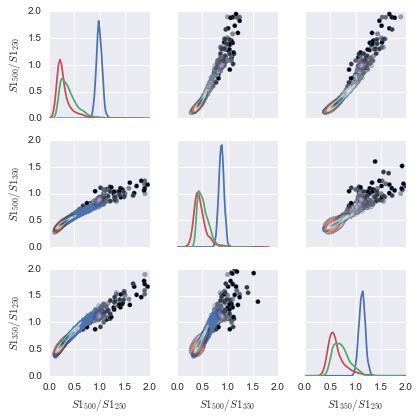

In [182]:
sns.set(rc={"figure.figsize": (10, 10)})
s1=17
s2=21
df = pd.DataFrame(posterior_red.stan_fit[:,:,[s1+((prior250_red.nsrc+1)*2),s1+((prior250_red.nsrc+1)*2),s1+prior250_red.nsrc+1]].reshape(2000,3)/posterior_red.stan_fit[:,:,[s1,s1+prior250_red.nsrc+1,s1]].reshape(2000,3),columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
g = sns.PairGrid(df,size=2)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="BuPu_d",n_levels=6,alpha=0.3)
g.data=pd.DataFrame(posterior_red.stan_fit[:,:,[s2+((prior250_red.nsrc+1)*2),s2+((prior250_red.nsrc+1)*2),s2+prior250_red.nsrc+1]].reshape(2000,3)/posterior_red.stan_fit[:,:,[s2,s2+prior250_red.nsrc+1,s2]].reshape(2000,3),columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
g.map_diag(sns.kdeplot,c='r')
g.map_offdiag(sns.kdeplot, cmap="OrRd_d", n_levels=6,alpha=0.5)
s3=21#np.arange(0,20,dtype='int')
#g.data=pd.DataFrame(posterior_red.stan_fit[:,:,[s3+((prior250_red.nsrc+1)*2),s3+((prior250_red.nsrc+1)*2),s3+prior250_red.nsrc+1]].reshape(2000,3,order='C')/posterior_red.stan_fit[:,:,[s3,s3+prior250_red.nsrc+1,s3]].reshape(2000,3,order='C'),columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
#g.map_diag(sns.kdeplot,c='g')
#g.map_offdiag(sns.kdeplot, cmap="GnBu", n_levels=6,alpha=0.5)
#g.map_lower(plt.scatter, cmap="GnBu",alpha=0.5)
for i in range(0,len(temps)):
    g.data=pd.DataFrame(np.array([col_berta[2,:,i]/col_berta[0,:,i],col_berta[2,:,i]/col_berta[1,:,i],col_berta[1,:,i]/col_berta[0,:,i]]).T,columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
    g.map_offdiag(plt.scatter,c=red)
#g.data=pd.DataFrame(np.array([col_berta[2,:,1]/col_berta[0,:,1],col_berta[2,:,1]/col_berta[1,:,1],col_berta[1,:,1]/col_berta[0,:,1]]).T,columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
#g.map_offdiag(plt.scatter,c=red)


g.data=pd.DataFrame(np.array([fcat['S500']/fcat['S250'],fcat['S500']/fcat['S350'],fcat['S350']/fcat['S250']]).T,columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
g.map_diag(sns.kdeplot,c='g')
g.map_offdiag(sns.kdeplot, cmap="GnBu", n_levels=6,alpha=0.5)
g.map_lower(plt.scatter, cmap="GnBu",alpha=0.5)

g.set(ylim=(0,2))
g.set(xlim=(0,2))

In [119]:
posterior_red.Rhat

array([ 1.00430893,  1.00176184,  0.99999748,  1.00218386,  1.00373523,
        1.0059014 ,  1.00383033,  1.00312367,  1.00689742,  1.00318635,
        1.00249296,  1.00047366,  1.00119309,  1.00053238,  1.01074348,
        0.99945159,  1.00533398,  0.9995916 ,  1.00138971,  1.00050722,
        0.99951703,  1.00310619,  0.99928938,  1.0018523 ,  1.00210287,
        0.99975845,  1.00077406,  1.0042056 ,  1.00508342,  1.00331341,
        1.00171219,  1.00474082,  1.00219721,  1.0010375 ,  1.00043787,
        1.00067198,  1.00063654,  1.01014718,  1.00014862,  1.00537865,
        0.99925299,  1.00120108,  1.00105489,  0.99979135,  1.0029187 ,
        1.001003  ,  1.0004094 ,  1.00111808,  0.99964832,  0.99976497,
        1.00229321,  1.00323619,  1.00105891,  0.99959648,  1.00270631,
        1.00234514,  1.001337  ,  0.99978677,  1.00000438,  1.00011215,
        1.01002348,  1.00034143,  1.00488463,  0.99908384,  1.00146291,
        1.00099334,  1.00011367,  1.00188499,  0.99837515,  0.99

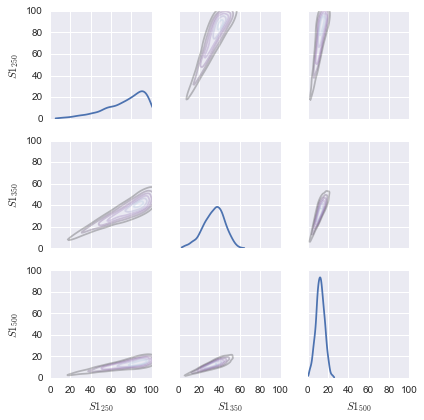

In [181]:
s1=1
df = pd.DataFrame(posterior_red.stan_fit[:,:,[s1,s1+prior250_red.nsrc+1,s1+((prior250_red.nsrc+1)*2)]].reshape(2000,3),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$'])
g = sns.PairGrid(df,size=2)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="BuPu_d",n_levels=6,alpha=0.3)
#g.data=pd.DataFrame(posterior_red.stan_fit[:,:,[s2+((prior250_red.nsrc+1)*2),s2+((prior250_red.nsrc+1)*2),s2+prior250_red.nsrc+1]].reshape(2000,3)/posterior_red.stan_fit[:,:,[s2,s2+prior250_red.nsrc+1,s2]].reshape(2000,3),columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
#g.map_diag(sns.kdeplot,c='r')
#g.map_offdiag(sns.kdeplot, cmap="OrRd_d",shade=True, n_levels=6,alpha=0.5)

g.set(ylim=(0,100))
g.set(xlim=(0,100))

In [206]:
dir(g)

['__call__',
 '__class__',
 '__cmp__',
 '__delattr__',
 '__doc__',
 '__format__',
 '__func__',
 '__get__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'im_class',
 'im_func',
 'im_self']

In [138]:
posterior_red.stan_fit.shape,24*3

((500, 4, 73), 72)

In [142]:
s2=21
print s2+((prior250_red.nsrc+1)*2)

67


In [140]:
prior250_red.nsrc

22

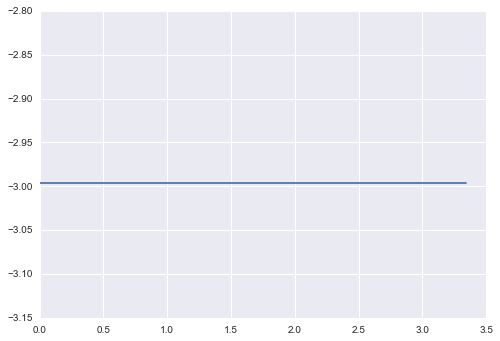

In [168]:
plt.plot(red,redpdf[20,:])

In [189]:
from tempfile import NamedTemporaryFile
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from matplotlib import animation
from IPython.display import HTML


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [209]:
# First set up the figure, the axis, and the plot element we want to animate
s1=0
df = pd.DataFrame(posterior_red.stan_fit[:,:,[s1+((prior250_red.nsrc+1)*2),s1+((prior250_red.nsrc+1)*2),s1+prior250_red.nsrc+1]].reshape(2000,3)/posterior_red.stan_fit[:,:,[s1,s1+prior250_red.nsrc+1,s1]].reshape(2000,3),columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
g = sns.PairGrid(df,size=2)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="BuPu_d",n_levels=6,alpha=0.3)
g.set(ylim=(0,2))
g.set(xlim=(0,2))

def animate(i):
    s2=i
    df=pd.DataFrame(posterior_red.stan_fit[:,:,[s2+((prior250_red.nsrc+1)*2),s2+((prior250_red.nsrc+1)*2),s2+prior250_red.nsrc+1]].reshape(2000,3)/posterior_red.stan_fit[:,:,[s2,s2+prior250_red.nsrc+1,s2]].reshape(2000,3),columns=[r'$S1_{500}/S1_{250}$',r'$S1_{500}/S1_{350}$',r'$S1_{350}/S1_{250}$'])
    g.data=df
    g.map_diag(sns.kdeplot)
    g.map_offdiag(sns.kdeplot, cmap="OrRd_d", n_levels=6,alpha=0.5)
    return g


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(g.fig, animate,
                               frames=19, interval=1000)

#anim.save('test_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

ValueError: Axes instance argument was not found in a figure.